# Tokenization
The goal of this notebook is to decide on a pre-built tokenization algorithm for the sample JSON data. 

In [1]:
import tensorflow as tf
import pandas as pd 
import os
import json 
import numpy as np
import tensorflow_text as text
import ast
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Test WordPiece Vocabulary
WordPiece is BERTs tokenizer and we can use it to generate a custom vocabulary from our data. This is a test with a sample JSON to see what this kind of vocab would look like. This is a potential alternative to a custom algorithm as it creates a vocab iteratively from subwords. 
Requires: tensorflow_text_nightly and tf-nightly

Testing with different vocabulary length yielded mixed results where it was sometimes able to effectively pick out pertinent tokens but mostly fixated on smaller tokens found in the structure of the JSON file or behavior parameters, most of which being unnecessary. A custom algorithm or reference dictionary will likely need to be developed.

In [ ]:
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

In [ ]:
# Takes rand sample of data to form test dataset for dict building

adware_sample = np.random.randint(0, high=886, size=(1,100))
banking_sample = np.random.randint(0, high=2048, size=(1,100))
riskware_sample = np.random.randint(0, high=2373, size=(1,100))
sms_sample = np.random.randint(0, high=3852, size=(1,100))

sample_mat = np.concatenate((adware_sample, banking_sample), axis=0)
sample_mat = np.concatenate((sample_mat, riskware_sample), axis=0)
sample_mat = np.concatenate((sample_mat, sms_sample), axis=0)

dir_list = ['adware', 'banking', 'riskware', 'sms']

# train_data = tf.data.TextLineDataset(str('adware\\' + os.listdir('adware')[sample_mat[0,0]] + '\\sample_for_analysis.apk.json'))

# mat_index = 0
# for sample_dir in dir_list: 
#     sample_list = os.listdir(sample_dir)
#     if sample_dir is 'adware':
#         start_index = 1
#     else:
#         start_index = 0
#     for rand_ind in sample_mat[mat_index,start_index:]:
#         train_data.concatenate(tf.data.TextLineDataset(str(sample_dir + '\\' + sample_list[rand_ind] + '\\sample_for_analysis.apk.json')))
#     mat_index += 1

In [ ]:
# bert_tokenizer_params=dict(lower_case=True)
# reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

# bert_vocab_args = dict(
#     # The target vocabulary size
#     vocab_size = 800,
#     # Reserved tokens that must be included in the vocabulary
#     reserved_tokens=reserved_tokens,
#     # Arguments for `text.BertTokenizer`
#     bert_tokenizer_params=bert_tokenizer_params,
#     # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
#     learn_params={},
# )

# test_vocab = bert_vocab.bert_vocab_from_dataset(
#     train_data.shuffle(45).batch(45).prefetch(2),
#     **bert_vocab_args
# )

# with open('test_vocab_rand_sample.txt', 'w') as f:
#     for token in test_vocab:
#         print(token, file=f)

## Custom Tokenization
Due to the apparent underperformance of pre-built models in deriving their own dictionaries, a custom method is required. The goal of this process is to derive reusable tokens and preserve the contextual, nested structure of the JSON file. We will do this by iteratively extracting tokens from a random sample until no meaningful (frequent) tokens remain.

In [ ]:
#grabs rand sample from mat above
sample_data = []

mat_index = 0
for sample_dir in dir_list: 
    sample_list = os.listdir(sample_dir)
    for rand_ind in sample_mat[mat_index, 0:]:
        with open(sample_dir + '\\' + sample_list[rand_ind] + '\\sample_for_analysis.apk.json') as sample_file:
            sample_data.append(sample_file.read().replace("\n", " "))
    mat_index += 1

In [ ]:
# See the frequency of all high level keys
high_keys = []

for sample in sample_data:
    sample_json = json.loads(sample)['behaviors']['dynamic']['host']
    for behavior in sample_json:
        for key in behavior.keys():
            high_keys.append(key)

high_uniq_keys, high_frequency = np.unique(high_keys, return_counts=True)
print(high_uniq_keys)
print(high_frequency)

### High Level Tokens
Inspection of high-level keys in a random sample revealed 11 keys
* class
* classType
* interface
* interfaceGroup
* method
* operationFlags
* procname
* subclass
* tid
* low
* arguments
#
Of these 11, low contains lower-level features as a list of dicts. arguments contains a list of strings

In [ ]:
# See the frequency of low-level tokens
low_keys = []
for sample in sample_data:
    sample_json = json.loads(sample)['behaviors']['dynamic']['host']
    for behavior in sample_json:
        for low_behavior in behavior['low']:
            for key in low_behavior.keys():
                low_keys.append(key)

low_uniq_keys, low_frequency = np.unique(low_keys, return_counts=True)
print(low_uniq_keys)
print(low_frequency)

### Low Level Tokens
Inspection of high-level tokens in a random sample revealed 12 keys
* blob
* id
* methodName
* method_name
* parameters
* read fd
* socket fd
* sysname
* ts 
* type
* write fd
* xref
#
blob and parameters contain lowest-level features, where blob is a dict as a string and contains formatting abnormalities, it can also contain a normal string. parameters is a list of strings and/or ints
# 
methodName and method_name differ where the former seems to be used in the context of a BINDER class. The latter seems exclusive to the ACCESS PERSONAL INFO class, but still with type binder

In [ ]:
# See the frequency of low-level tokens
# lowest_keys = []
# for sample in sample_data:
#     sample_json = json.loads(sample)['behaviors']['dynamic']['host']
#     for behavior in sample_json:
#         for low_behavior in behavior['low']:
#             for key in low_behavior.keys():
#                 if key == 'blob':
#                     string_dict = low_behavior['blob']
#                     if type(string_dict) is dict:
#                         for lowest_key in string_dict.keys():
#                             lowest_keys.append(lowest_key)
#                     else:
#                         string_dict = string_dict.replace("L,", ",")
#                         string_dict = string_dict.replace("L}", "}")
#                         string_dict = string_dict.replace("u\'", "\'")
#                         string_dict = string_dict.replace("\'", "\"")
#                         try:
#                             string_dict = ast.literal_eval(string_dict)
#                         except:
#                             pass
#                         if type(string_dict) is dict:
#                             for lowest_key in string_dict.keys():
#                                 lowest_keys.append(lowest_key)

# lowest_uniq_keys, lowest_frequency = np.unique(lowest_keys, return_counts=True)
# print(lowest_uniq_keys)
# print(lowest_frequency)

### Lowest Level Tokens
Keys in blob contained wildly varying frequencies, see the sample output below:
#
['devicename' 'dirname' 'filename' 'flags' 'host' 'mode' 'pid' 'port'
 'query_data' 'returnValue' 'size' 'socket domain' 'socket protocol'
 'socket type' 'status' 'tid' 'type']
 #
[215011   1163 650182  58849   3282  60002   8869   3282    123   3282
 530656   5927   5927   5927   2277   8869   5506]
 #
I'm not entirely sure how much this data will be explicitly tokenized by a custom algorithm. There are many many inconsistencies in the parsing of the string into JSON that causes it to throw out a lot of values. This could likely be compensated for, but in the interest of time it may be better to avoid it and explore the useage of a pre-built algo on the string, like what is planned for parameters and arguments.

### Token Extraction
With high and low level keys extracted, the next step of building the tokens is to look at the number and distribution of possible values for each token. This will be done by making a dataframe for each unique key with the key being the col and each observed value as the rows. The dataframe will then be made into a piechart with matplotlib and saved to jpg for inspection with a caption containing the number of unique values.
#
Excluded keys:
* parameters
* id
* blob
* xref
* ts 
* arguments
* tid
#
These will be excluded from tokenization as they are identifiers and/or contain lists or dicts not for explicit tokenization.

In [ ]:
exclude_keys = ['parameters', 'id', 'blob', 'xref', 'ts', 'arguments', 'tid']

master_dict = {
    'methodName': [],
    'method_name': [],
    'read fd': [],
    'socket fd': [],
    'sysname': [],
    'type': [],
    'write fd': [],
    'class': [],
    'classType': [],
    'interface': [],
    'interfaceGroup': [],
    'method': [],
    'operationFlags': [],
    'procname': [],
    'subclass': []
}

for sample in sample_data:
    sample_json = json.loads(sample)['behaviors']['dynamic']['host']
    for behavior in sample_json:
        for key, value in behavior.items():
            if key not in exclude_keys and key != 'low':
                master_dict[key].append(value)
            elif key == 'low':
                for low_behavior in value:
                    for low_key, low_value in low_behavior.items():
                        if low_key not in exclude_keys:
                            master_dict[low_key].append(low_value)
                        else:
                            continue
            else:
                continue

In [ ]:
for ref_key, total_values in master_dict.items():
    if ref_key in high_uniq_keys:
        total_count = high_frequency[np.where(high_uniq_keys == ref_key)[0][0]]
        num_values = len(total_values)
        len_match = total_count == num_values
        print(ref_key + ': ')
        print(len_match)
        print('\n')
    elif ref_key in low_uniq_keys:
        total_count = low_frequency[np.where(low_uniq_keys == ref_key)[0][0]]
        num_values = len(total_values)
        len_match = total_count == num_values
        print(ref_key + ': ')
        print(len_match)
        print('\n')
    df = pd.DataFrame(total_values, columns=[ref_key])
    with open('token_extraction\\csvs\\' + ref_key + '.csv', 'w') as write_csv:
        df.to_csv(write_csv, index=False)

In [6]:
def make_plots(dataframe):
    dataframe.fillna("NaN", inplace=True)
    dataframe = dataframe.astype("category")

    key_name = dataframe.columns.values.tolist()[0]
    values = dataframe[key_name].to_numpy()
    categories, counts = np.unique(values, return_counts=True)

    plt.style.use('seaborn-muted')

    plot, (top, bottom) = plt.subplots(2, figsize=[10, 18])
    plot.suptitle("Makeup and Frequency of Unique Values for Key: " + key_name)

    top.pie(counts, labels=categories, autopct='%1.1f%%')
    top.axis('equal')
    top.set_title("Makeup of Unique Values for Key: " + key_name)
    top.legend(frameon=False, bbox_to_anchor=(1.5,0.8))

    sns.histplot(ax=bottom, data=dataframe, y=key_name, hue=key_name, shrink=.8, discrete=True, multiple="dodge")
    bottom.set_title("Frequency of Unique Values for Key: " + key_name)

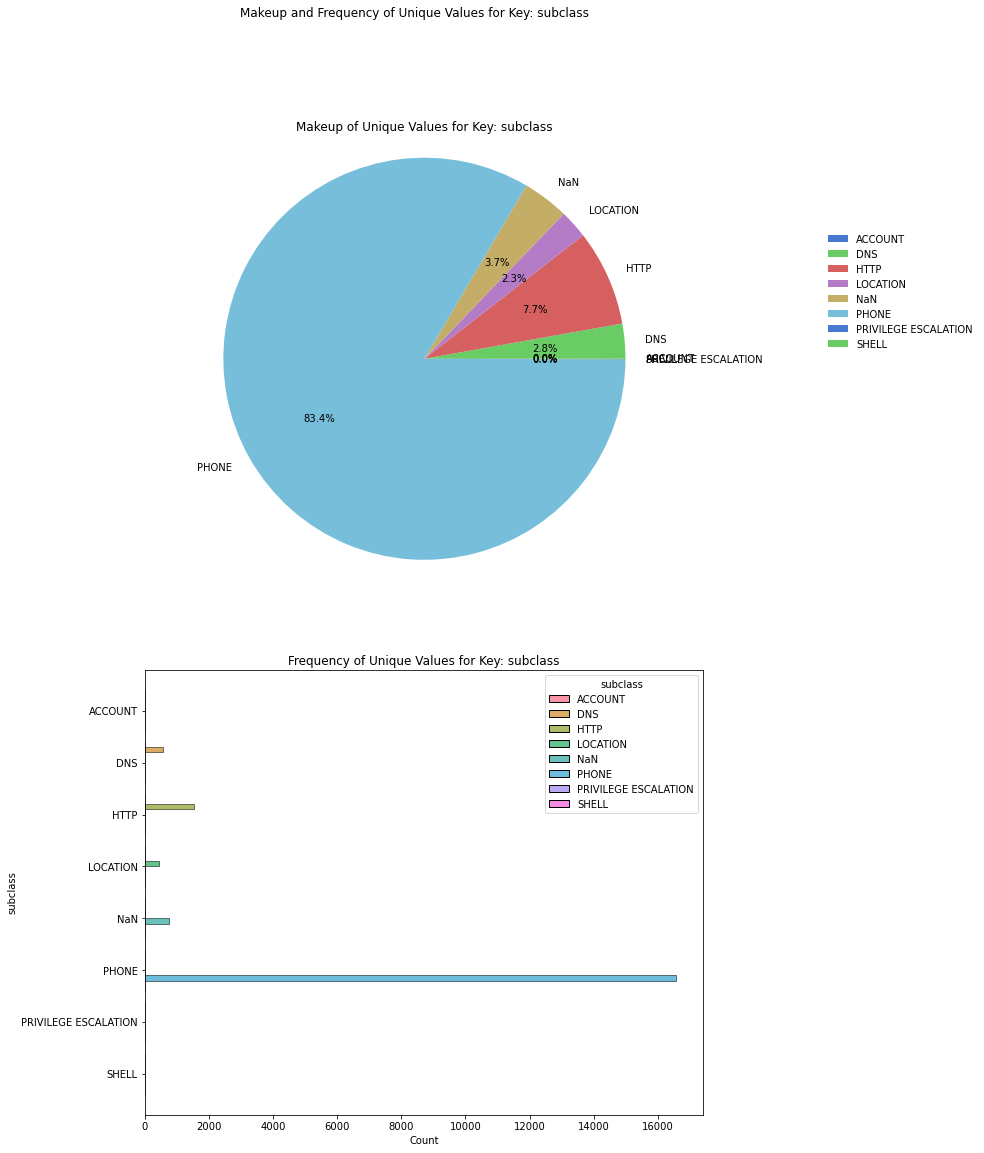

In [7]:
with open('token_extraction\csvs\subclass.csv') as test_path:
    data = pd.read_csv(test_path)

make_plots(data)

## ID and TS Features